In [160]:
from tms_risk.cogmodels.fit_model import build_model, get_data
from tms_risk.cogmodels.utils import plot_prediction, stimulation_order, stimulation_palette
import seaborn as sns
import arviz as az
import os.path as op
import pandas as pd
import matplotlib.pyplot as plt
from bauer.utils.math import softplus_np
import numpy as np
from bauer.models import FlexibleNoiseRiskRegressionModel
from tqdm import tqdm
import pandas as pd

bids_folder = '/data/ds-tmsrisk'

# Some convenience functions
def get_info(model_label, bids_folder='/data/ds-tmsrisk'):

    df = get_data(model_label=model_label, bids_folder=bids_folder)
    model = build_model(df=df, model_label=model_label)
    idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', f'model-{model_label}_trace.netcdf'))

    return df, model, idata

In [161]:
conditions = pd.DataFrame([{'stimulation_condition':'vertex'},
                            {'stimulation_condition':'ips'}])

model_label = 'flexible2'

df, model, idata = get_info(model_label)
model.build_estimation_model()
curves = model.get_sd_curve(conditions, idata=idata.sel(draw=slice(None, None,25)), x=np.arange(7, 113), variable='both', group=False)

In [162]:
prior = model.get_conditionwise_parameters(conditions=conditions, idata=idata.sel(draw=slice(None, None,25)), group=False)
mean_priors = prior.loc[['risky_prior_mu', 'risky_prior_sd', 'safe_prior_mu', 'safe_prior_sd']].groupby(['subject', 'parameter']).mean().stack().to_frame('value')
mean_priors.index = mean_priors.index.set_levels(
    mean_priors.index.levels[mean_priors.index.names.index('stimulation_condition')].map({'vertex': 'Vertex', 'ips': 'IPS'}),
    level='stimulation_condition'
)

In [163]:
curves['n1_evidence_sd'] = curves['memory_noise_sd'] + curves['perceptual_noise_sd']
curves['n2_evidence_sd'] = curves['perceptual_noise_sd']


In [164]:
mean_curves = curves.groupby(['subject', 'stimulation_condition', 'x']).mean()

mean_curves.index = mean_curves.index.set_levels(
    mean_curves.index.levels[mean_curves.index.names.index('stimulation_condition')].map({'vertex': 'Vertex', 'ips': 'IPS'}),
    level='stimulation_condition'
)

In [165]:
frac = 2**np.linspace(0.0, 2., 6)
frac = np.quantile(df['frac'], np.linspace(0, 1, 8)[1:-1])
safe_n = np.array([7, 10, 14, 20, 28])

paradigm = pd.MultiIndex.from_product([safe_n, frac, [0.55, 1.0]], names=['n_safe', 'frac', 'p1']).to_frame(index=False)
paradigm['n_risky'] = np.round(paradigm['n_safe'] * paradigm['frac'])
paradigm['risky_first'] = paradigm['p1'] == 0.55
# p2 is .55 when p1 is 1.0, and 1.0 when p1 is .55
paradigm['p2'] = np.where(paradigm['p1'] == 0.55, 1.0, 0.55)
paradigm['n1'] = np.where(paradigm['risky_first'], paradigm['n_risky'], paradigm['n_safe'])
paradigm['n2'] = np.where(paradigm['risky_first'], paradigm['n_safe'], paradigm['n_risky'])

# paradigm.drop('frac', axis=1, inplace=True)


In [166]:
from bauer.utils.bayes import get_posterior
def get_ev_risky(row, mean_curves=mean_curves, priors=mean_priors):

    evidence_sd_key = 'n1_evidence_sd' if row['risky_first'] else 'n2_evidence_sd'
    result = get_posterior(row['n_risky'], mean_curves.xs(row['n_risky'], level='x')[evidence_sd_key], mean_priors.xs('risky_prior_mu', level='parameter')['value'], mean_priors.xs('risky_prior_sd', level='parameter')['value'])[0]

    return .55 * result

def get_ev_safe(row, mean_curves=mean_curves, priors=mean_priors):

    evidence_sd_key = 'n2_evidence_sd' if row['risky_first'] else 'n1_evidence_sd'
    result = get_posterior(row['n_safe'], mean_curves.xs(row['n_safe'], level='x')[evidence_sd_key], mean_priors.xs('safe_prior_mu', level='parameter')['value'], mean_priors.xs('safe_prior_sd', level='parameter')['value'])[0]

    return result







In [167]:
ev_risky = paradigm.apply(get_ev_risky, axis=1)
ev_risky.index = pd.MultiIndex.from_frame(paradigm)

ev_safe = paradigm.apply(get_ev_safe, axis=1)
ev_safe.index = pd.MultiIndex.from_frame(paradigm)

ev_risky = ev_risky.stack(level=[0, 1]).to_frame('EV_percept[risky]')
ev_safe = ev_safe.stack(level=[0, 1]).to_frame('EV_percept[safe]')

ev = pd.concat([ev_risky, ev_safe], axis=1)

ev['EV[risky]'] = ev.index.get_level_values('n_risky') * .55
ev['EV[safe]'] = ev.index.get_level_values('n_safe')


ev['error_risky'] = ev['EV_percept[risky]'] / ev['EV[risky]']
ev['error_safe'] = ev['EV_percept[safe]'] / ev['EV[safe]']
error_diff = (ev['error_risky'] - ev['error_safe']).to_frame('error_diff')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_74458/891503106.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  ev_risky = ev_risky.stack(level=[0, 1]).to_frame('EV_percept[risky]')
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_74458/891503106.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  ev_safe = ev_safe.stack(level=[0, 1]).to_frame('EV_percept[safe]')


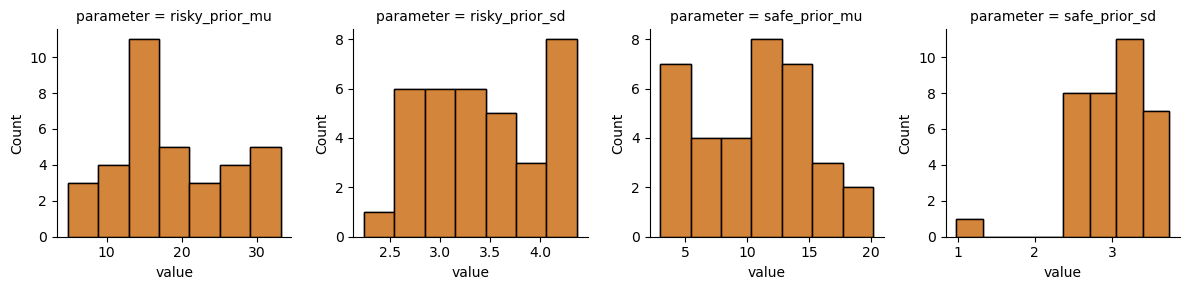

In [171]:
g = sns.FacetGrid(mean_priors.reset_index(), hue='stimulation_condition', col='parameter', sharey=False, sharex=False)

g.map(sns.histplot, 'value')

Text(0.5, 1.05, 'Perceived expected value as a function of real expected value')

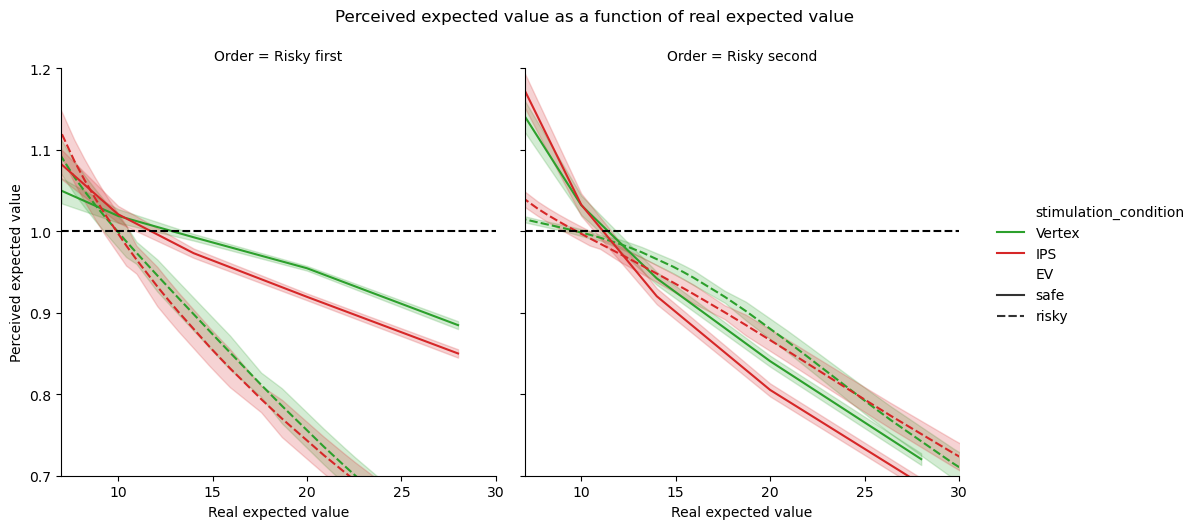

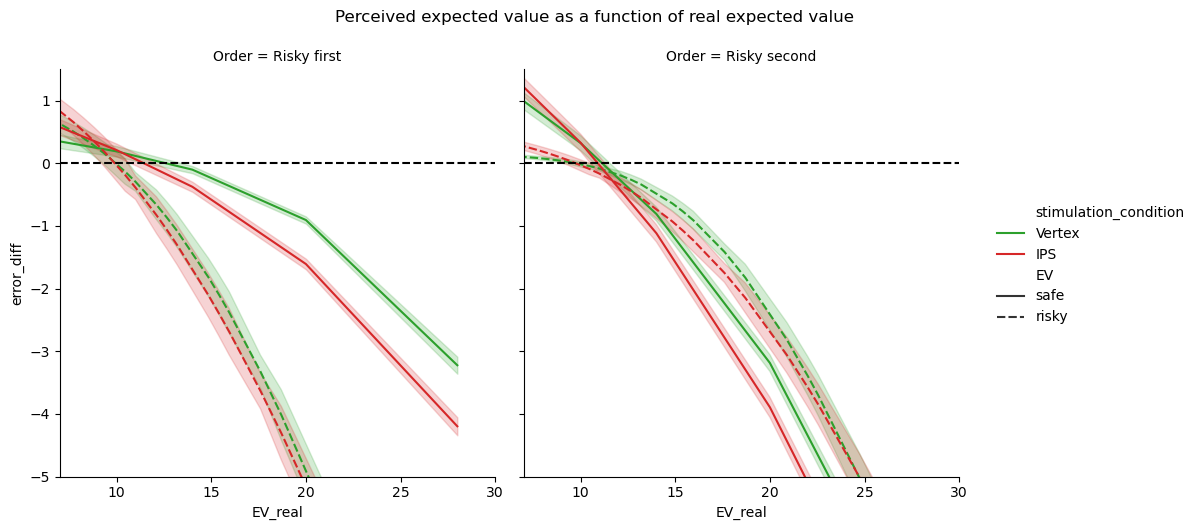

In [175]:
# ev_safe = ev.set_index(['subject', 'stimulation_condition', 'risky_first'])[['EV[safe]', 'EV_percept[safe]']]
ev_safe = ev[['EV[safe]', 'EV_percept[safe]']]
ev_safe.columns = ['EV_real', 'EV_perceived']


# ev_risky = ev.set_index(['subject', 'stimulation_condition', 'risky_first'])[['EV[risky]', 'EV_percept[risky]']]
ev_risky = ev[['EV[risky]', 'EV_percept[risky]']]
ev_risky.columns = ['EV_real', 'EV_perceived']

tmp = pd.concat((ev_safe, ev_risky), keys=['safe', 'risky'], names=['EV'], axis=0)
tmp.set_index(pd.Index(tmp['EV_real'], name='x'), append=True, inplace=True)
tmp = tmp.join(mean_curves[['n1_evidence_sd', 'n2_evidence_sd']])

tmp['sd'] = tmp['n1_evidence_sd'].where(((tmp.index.get_level_values('EV') == 'risky') & tmp.index.get_level_values('risky_first')) | 
                                        ((tmp.index.get_level_values('EV') == 'safe') & (~tmp.index.get_level_values('risky_first'))), tmp['n2_evidence_sd'])

tmp['sd'] = tmp['n2_evidence_sd'].where(((tmp.index.get_level_values('EV') == 'risky') & (~tmp.index.get_level_values('risky_first')) |
                                        ((tmp.index.get_level_values('EV') == 'safe') & tmp.index.get_level_values('risky_first'))), tmp['n1_evidence_sd'])


tmp['error_ratio'] = tmp['EV_perceived'] / tmp['EV_real']
tmp['error_diff'] = tmp['EV_perceived'] - tmp['EV_real']
tmp['error_diff_sd'] = tmp['error_diff'] / tmp['sd']

tmp = tmp.reset_index()

tmp['Order'] = tmp['risky_first'].map({True: 'Risky first', False: 'Risky second'})

g = sns.relplot(x='EV_real', y='error_ratio', data=tmp.reset_index(), hue='stimulation_condition', col='Order', kind='line', style='EV', palette=stimulation_palette,
            hue_order=stimulation_order, errorbar='se', col_order=['Risky first', 'Risky second'])

g.set(xlim=(7, 30), ylim=(.7, 1.2))

g.map(plt.axhline, y=1.0, c='k', ls='--')

g.fig.suptitle('Perceived expected value as a function of real expected value', y=1.05)

g.set(xlabel='Real expected value', ylabel='Perceived expected value',)


g2 = sns.relplot(x='EV_real', y='error_diff', data=tmp.reset_index(), hue='stimulation_condition', col='Order', kind='line', style='EV', palette=stimulation_palette,
            hue_order=stimulation_order, errorbar='se', col_order=['Risky first', 'Risky second'])  

g2.set(xlim=(7, 30), ylim=(-5, 1.5))

g2.map(plt.axhline, y=0.0, c='k', ls='--')

g2.fig.suptitle('Perceived expected value as a function of real expected value', y=1.05)



# g3 = sns.relplot(x='EV_real', y='error_diff_sd', data=tmp.reset_index(), hue='stimulation_condition', col='Order', kind='line', style='EV', palette=stimulation_palette,
#             hue_order=stimulation_order, errorbar='se', col_order=['Risky first', 'Risky second'])

# g3.set(xlim=(7, 30), ylim=(-2, None))

# g3.map(plt.axhline, y=0.0, c='k', ls='--')


Text(0.5, 1.05, 'Difference EV[risky] - EV[safe] as a function of risky-safe ratio')

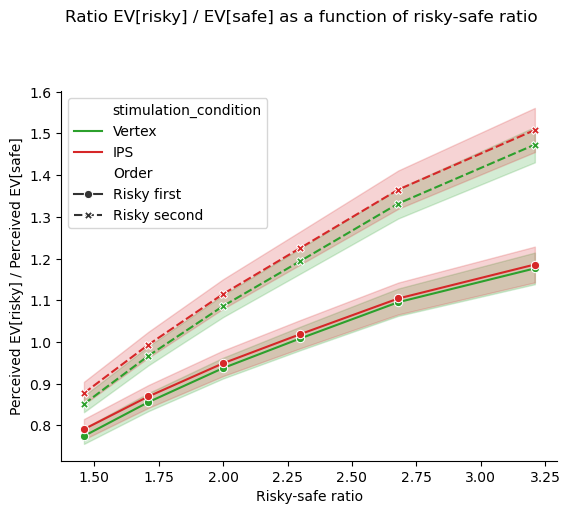

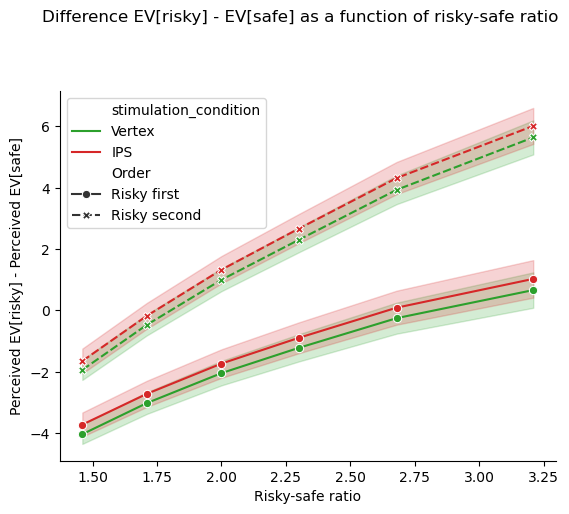

In [198]:
ev['ev_diff'] = ev['EV_percept[risky]'] - ev['EV_percept[safe]']
ev['ev_ratio'] = ev['EV_percept[risky]'] / ev['EV_percept[safe]']


ev = ev.reset_index('frac')
# ev
ev['frac'] = np.round(ev['frac'], 2)
ev['Order'] = ev.index.get_level_values('risky_first').map({True: 'Risky first', False: 'Risky second'})

ev = ev.set_index('frac', append=True)


g = sns.lineplot(x='frac', y='ev_ratio', data=ev.groupby(['subject', 'frac', 'stimulation_condition', 'Order'])['ev_ratio'].mean().reset_index(), hue='stimulation_condition', style='Order', markers=True, palette=stimulation_palette, hue_order=stimulation_order,
                 errorbar='se')

# frac = ev['frac'].unique()
# plt.plot(frac, frac*.55, c='k', ls='--')

sns.despine()

g.set(xlabel='Risky-safe ratio', ylabel='Perceived EV[risky] / Perceived EV[safe]')

plt.gcf().suptitle('Ratio EV[risky] / EV[safe] as a function of risky-safe ratio', y=1.05)

plt.figure()
g2 = sns.lineplot(x='frac', y='ev_diff', data=ev.groupby(['subject', 'frac', 'stimulation_condition', 'Order'])['ev_diff'].mean().reset_index(), hue='stimulation_condition', style='Order', markers=True, palette=stimulation_palette, hue_order=stimulation_order,
                    errorbar='se')

sns.despine()

g2.set(xlabel='Risky-safe ratio', ylabel='Perceived EV[risky] - Perceived EV[safe]')
plt.gcf().suptitle('Difference EV[risky] - EV[safe] as a function of risky-safe ratio', y=1.05)


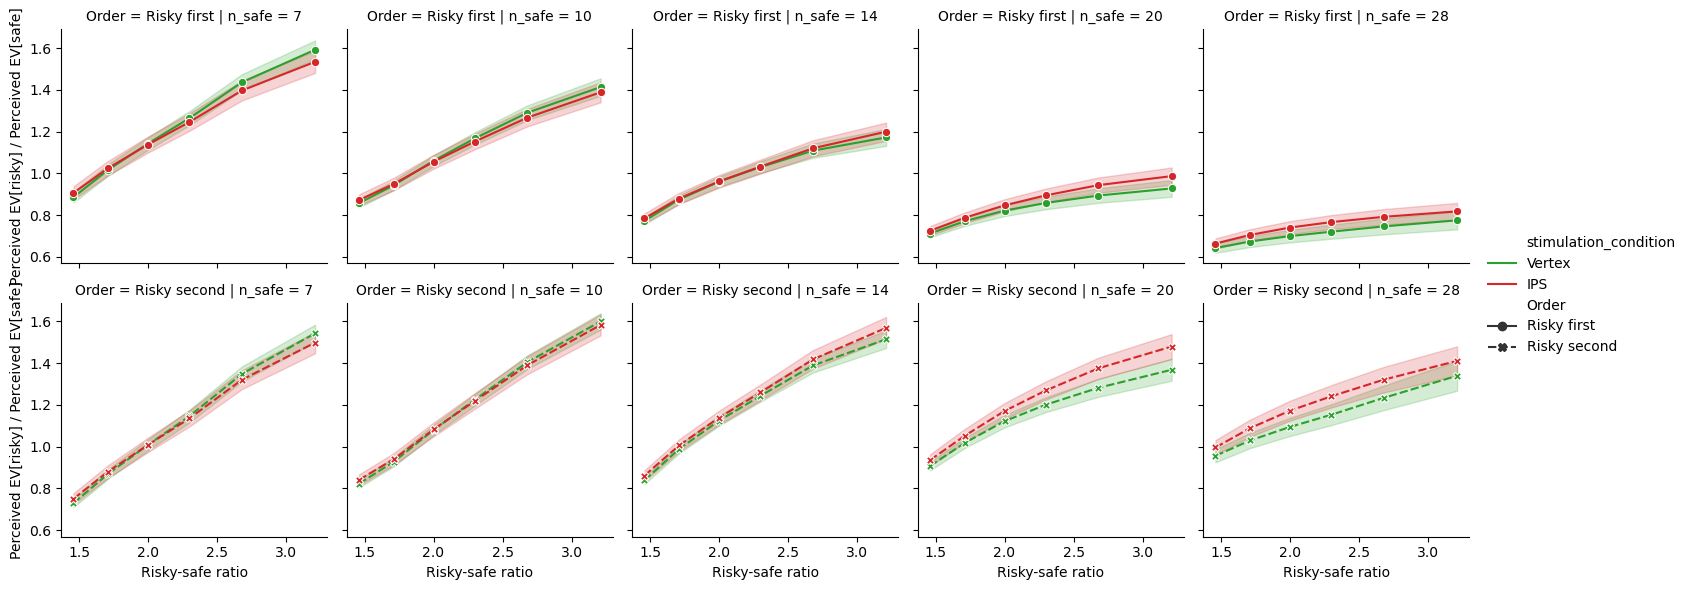

In [193]:
g = sns.relplot(col='n_safe', y='ev_ratio', data=ev.reset_index(), hue='stimulation_condition', style='Order', markers=True, x='frac', kind='line', errorbar='se', palette=stimulation_palette, hue_order=stimulation_order,
                height=3., row='Order')

# frac = ev['frac'].unique()
# plt.plot(frac, frac*.55, c='k', ls='--')

g.set(xlabel='Risky-safe ratio', ylabel='Perceived EV[risky] / Perceived EV[safe]')

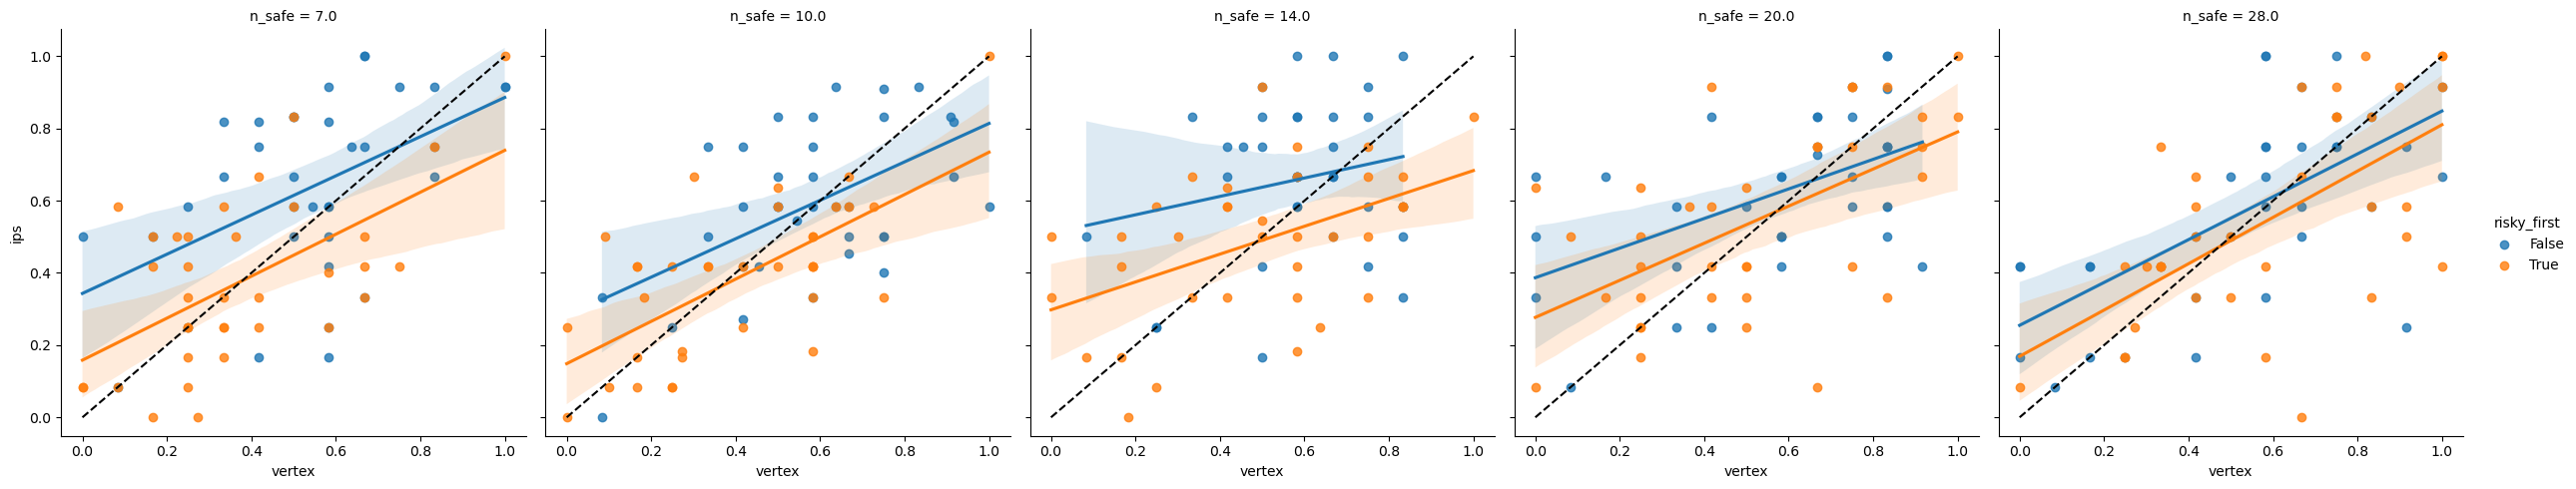

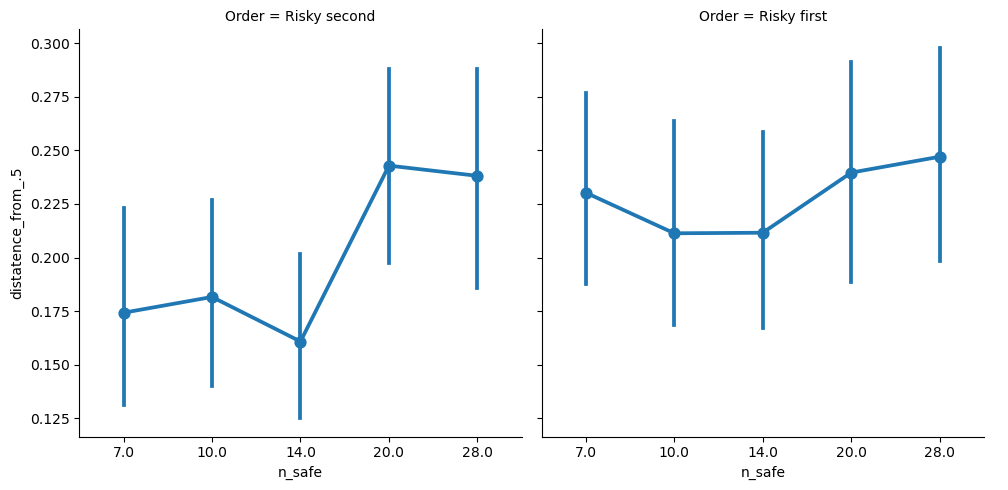

In [215]:
tmp = df.pivot_table(index=['subject', 'n_safe', 'risky_first'], columns=['stimulation_condition'], values='choice')

g = sns.lmplot(x='vertex', y='ips', data=tmp.reset_index(), col='n_safe', hue='risky_first')

# plot identity line
for ax in g.axes.flatten():
    ax.plot([0, 1], [0, 1], ls='--', c='k')


# tmp['vertex_choice'] = tmp['vertex'] > .5

# sns.catplot(x='n_safe', y='ips', data=tmp.reset_index(), hue='vertex_choice', col='risky_first', kind='point', )

# tmp

tmp['distatence_from_.5'] = np.abs(tmp['vertex'] - .5)

tmp = tmp.reset_index()

tmp['Order'] = tmp['risky_first'].map({True: 'Risky first', False: 'Risky second'})

g = sns.catplot(x='n_safe', y='distatence_from_.5', data=tmp, col='Order', kind='point', )

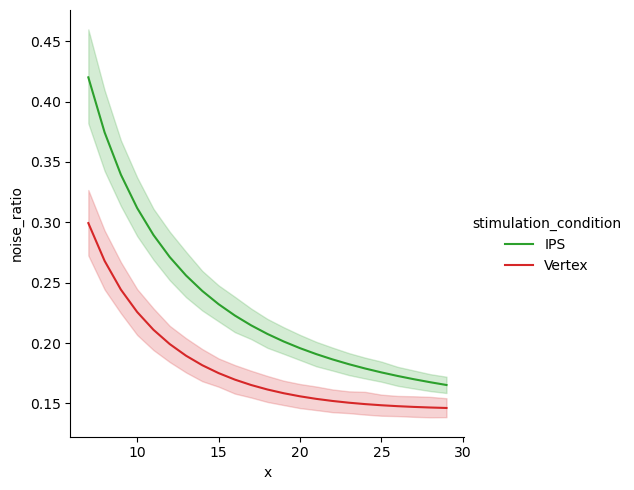

In [201]:
mean_curves['sum_evidence_sd'] = mean_curves['n1_evidence_sd'] + mean_curves['n2_evidence_sd']

mean_curves['noise_ratio'] = mean_curves['sum_evidence_sd'] / mean_curves.index.get_level_values('x')


g = sns.relplot(x='x', y='noise_ratio', data=mean_curves.xs(slice(None, 29), level='x', drop_level=False).reset_index(), hue='stimulation_condition', kind='line', palette=stimulation_palette,)


# # natural numbers on y axis
# g.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))

# # put a few ticks
# g.ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=10))


In [156]:
mean_curves.xs(slice(7, 10), level='x')['n1_evidence_sd']

subject  stimulation_condition
1        IPS                      1.527976
         IPS                      1.582533
         IPS                      1.638575
         IPS                      1.695987
         Vertex                   1.242368
                                    ...   
74       IPS                      2.002336
         Vertex                   1.845687
         Vertex                   1.885529
         Vertex                   1.929435
         Vertex                   1.977571
Name: n1_evidence_sd, Length: 280, dtype: float64

In [157]:
mean_curves

variable                           memory_noise_sd  perceptual_noise_sd  \
subject stimulation_condition x                                           
1       IPS                   7           0.781952             0.746024   
                              8           0.815311             0.767223   
                              9           0.848461             0.790113   
                              10          0.881316             0.814671   
                              11          0.913792             0.840865   
...                                            ...                  ...   
74      Vertex                108         2.110617             2.663315   
                              109         2.077631             2.566153   
                              110         2.043233             2.471497   
                              111         2.007549             2.379884   
                              112         1.970730             2.291778   

variable                           n1_evidence_sd  n2_evidence_sd  \
subject stimulation_condition x                                     
1       IPS                   7          1.527976        0.746024   
                              8          1.582533        0.767223   
                              9          1.638575        0.790113   
                              10         1.695987        0.814671   
                              11         1.754657        0.840865   
...                                           ...             ...   
74      Vertex                108        4.773932        2.663315   
                              109        4.643784        2.566153   
                              110        4.514730        2.471497   
                              111        4.387432        2.379884   
                              112        4.262508        2.291778   

variable                           sum_evidence_sd    ratio_sd  noise_ratio  
subject stimulation_condition x                                              
1       IPS                   7           2.274000    5.475981     0.324857  
                              8           2.349756    5.804913     0.293719  
                              9           2.428688    6.166444     0.269854  
                              10          2.510658    6.563374     0.251066  
                              11          2.595522    6.998757     0.235957  
...                                            ...         ...          ...  
74      Vertex                108         7.437247  236.653315     0.068863  
                              109         7.209938  201.471027     0.066146  
                              110         6.986227  171.906189     0.063511  
                              111         6.767316  147.132472     0.060967  
                              112         6.554286  126.412151     0.058520  

[7420 rows x 7 columns]

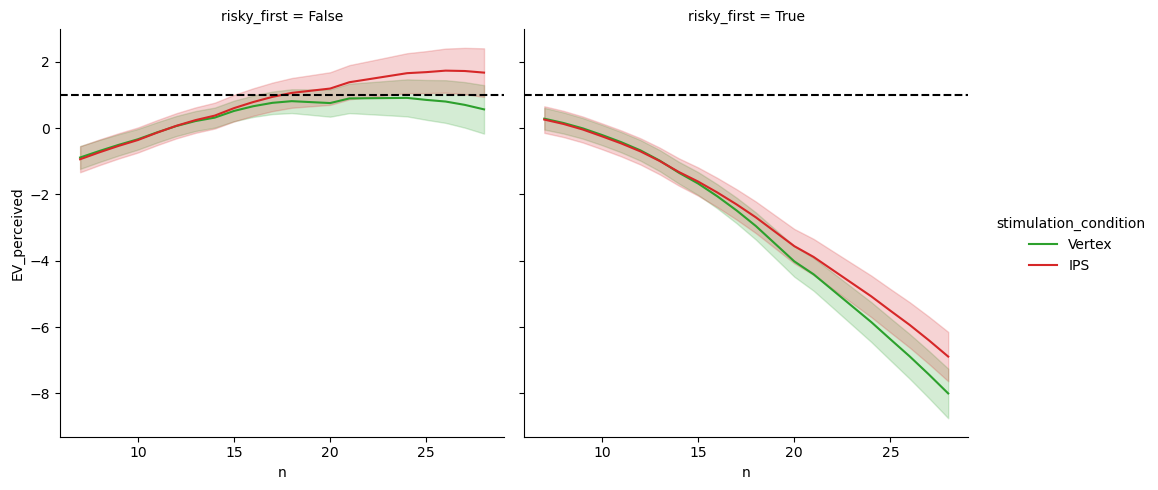

In [158]:
n = np.arange(7, 29, 1.)

tmp1 = ev_safe.groupby(['subject', 'stimulation_condition', 'risky_first']).apply(lambda d: pd.Series(np.interp(n, d['EV_real'], d['EV_perceived']), index=pd.Index(n, name='n'))).stack().to_frame("EV_perceived")
tmp2 = ev_risky.groupby(['subject', 'stimulation_condition', 'risky_first']).apply(lambda d: pd.Series(np.interp(n, d['EV_real'], d['EV_perceived']), index=pd.Index(n, name='n'))).stack().to_frame("EV_perceived")



ev_ratio = tmp2 - tmp1

g = sns.relplot(x='n', y='EV_perceived', data=ev_ratio.reset_index(), hue='stimulation_condition', col='risky_first', kind='line', palette=stimulation_palette, hue_order=stimulation_order,
                errorbar='se')

g.map(plt.axhline, y=1.0, c='k', ls='--')

In [159]:
# safe_function = tmp.loc['safe'].set_index('EV_real')['EV_perceived']



In [ ]:
# ev['ev_diff'] = ev['EV_percept[risky]'] - ev['EV_percept[safe]']
# ev['ev_ratio'] = ev['EV_percept[risky]'] / ev['EV_percept[safe]']


# ev = ev.reset_index()
# ev['frac'] = np.round(ev['frac'], 2)
# ev['Order'] = ev['risky_first'].map({True: 'Risky first', False: 'Risky second'})

Text(0.5, 1.05, 'Ratio EV[risky] / EV[safe] as a function of risky-safe ratio')

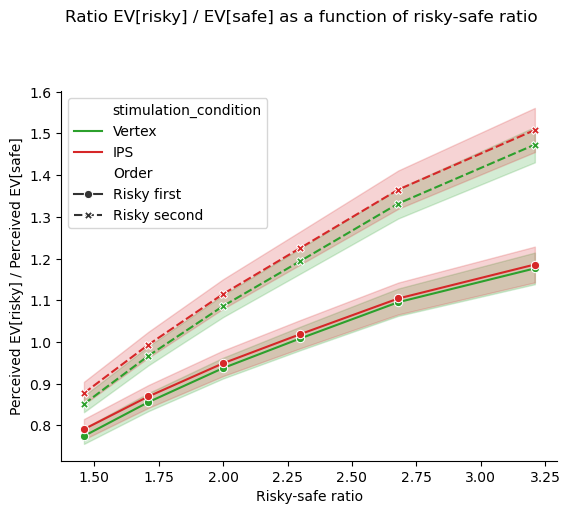

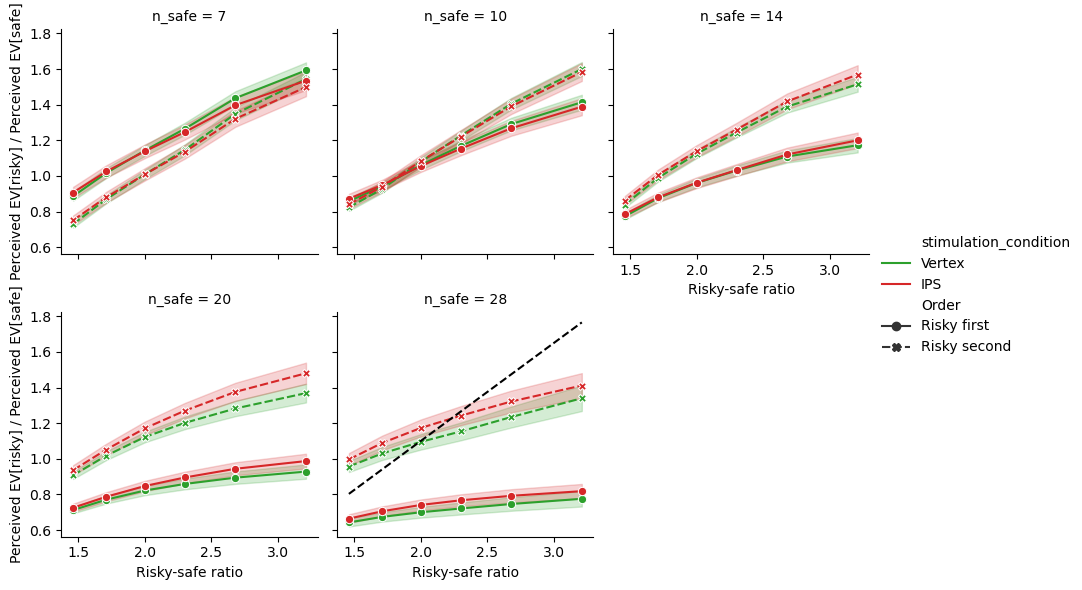

In [27]:
g = sns.relplot(x='frac', y='ev_ratio', data=ev, hue='stimulation_condition', style='Order', markers=True, col='n_safe', kind='line', errorbar='se', palette=stimulation_palette, hue_order=stimulation_order,
                col_wrap=3, height=3.)

frac = ev['frac'].unique()
plt.plot(frac, frac*.55, c='k', ls='--')

g.set(xlabel='Risky-safe ratio', ylabel='Perceived EV[risky] / Perceived EV[safe]')

Text(0.5, 1.0, 'IPS stimulation, Risky second')

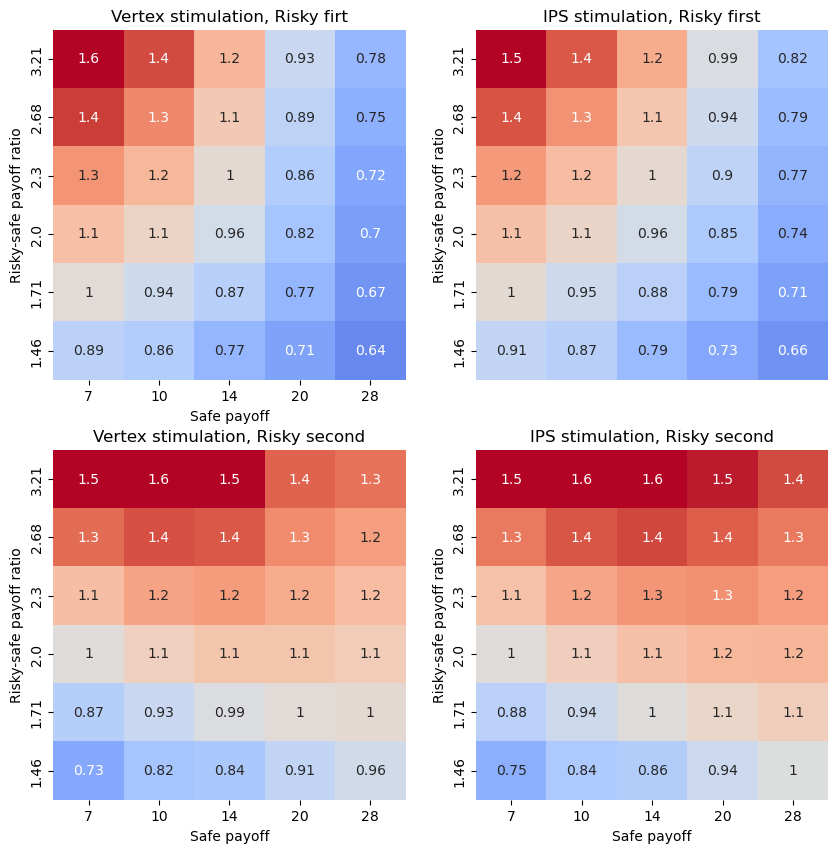

In [301]:

tables = ev.pivot_table(index=['stimulation_condition', 'risky_first', 'frac'], columns=['n_safe'], values='ev_ratio')




vmin, vmax = .5, 1.5

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

ax = sns.heatmap(tables.loc['Vertex', True].iloc[::-1], annot=True, cmap='coolwarm', center=1, vmin=vmin, vmax=vmax, ax=axs[0, 0], cbar=False)
ax.set(xlabel='Safe payoff', ylabel='Risky-safe payoff ratio')
ax.set_title('Vertex stimulation, Risky firt')

ax = sns.heatmap(tables.loc['IPS', True].iloc[::-1], annot=True, cmap='coolwarm', center=1, vmin=vmin, vmax=vmax, ax=axs[0, 1], cbar=False)
ax.set(xlabel=None, ylabel='Risky-safe payoff ratio', xticks=[])
ax.set_title('IPS stimulation, Risky first')

ax = sns.heatmap(tables.loc['Vertex', False].iloc[::-1], annot=True, cmap='coolwarm', center=1, vmin=vmin, vmax=vmax, ax=axs[1, 0], cbar=False)
ax.set(xlabel='Safe payoff', ylabel='Risky-safe payoff ratio')
ax.set_title('Vertex stimulation, Risky second')

ax = sns.heatmap(tables.loc['IPS', False].iloc[::-1], annot=True, cmap='coolwarm', center=1, vmin=vmin, vmax=vmax, ax=axs[1, 1], cbar=False)
ax.set(xlabel='Safe payoff', ylabel='Risky-safe payoff ratio')
ax.set_title('IPS stimulation, Risky second')

# plt.figure()
# g = sns.heatmap(tables.loc['ips', True].iloc[::-1], annot=True, cmap='coolwarm', center=0, vmin=-10, vmax=10)
# g.set(xlabel='Safe payoff', ylabel='Risky-safe payoff ratio')

Text(0.5, 1.025, 'Ratio of perceived EV[Risky] over EV[safe]')

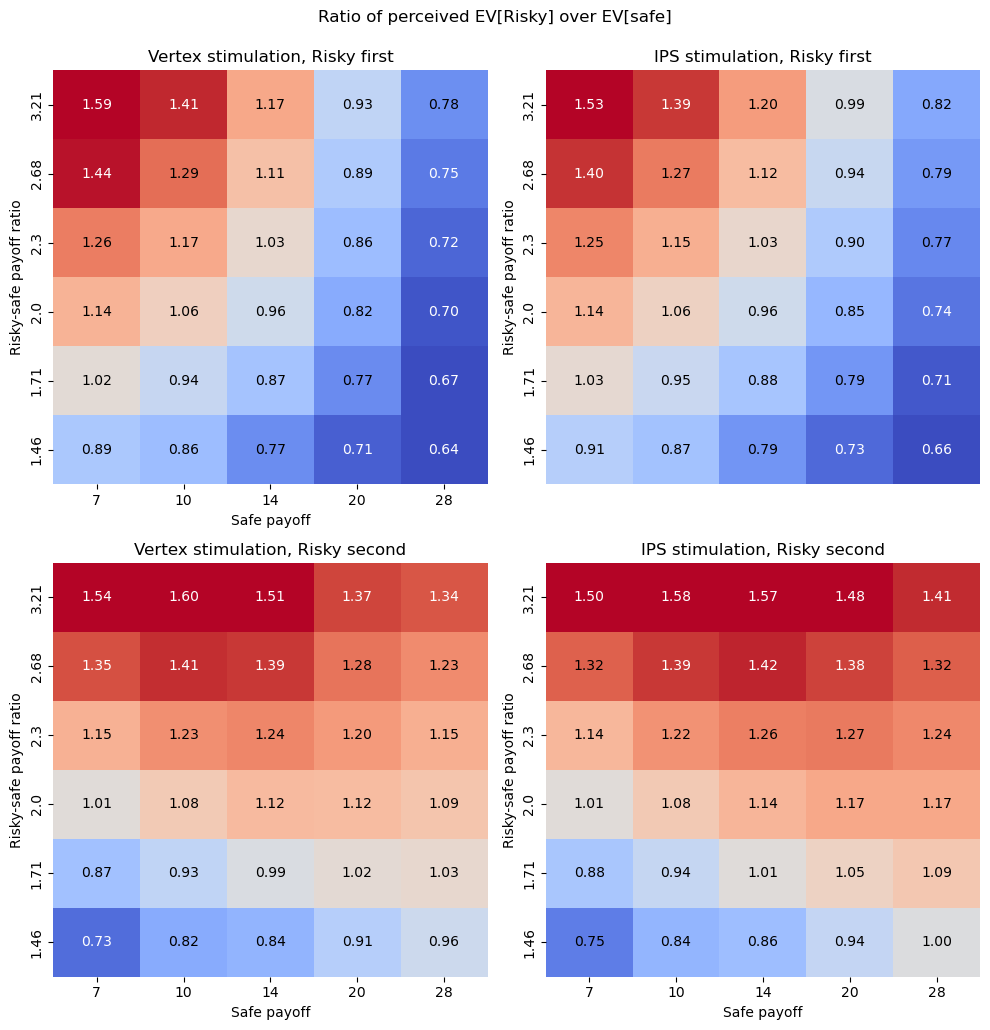

In [312]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# Log-transform the data for color mapping
log_tables = np.log(tables)

# Custom annotation function to adjust text color based on cell background color
def annotate_heatmap(data, ax, original_data, fmt=".2f", threshold=0.5):
    # Normalize log data to map colors correctly
    norm = mcolors.Normalize(vmin=np.log(vmin), vmax=np.log(vmax))
    cmap = plt.get_cmap('coolwarm')

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            # Get the original value for annotation
            original_value = original_data.iloc[i, j]
            color_value = data.iloc[i, j]
            
            # Determine background color for the cell
            rgb = cmap(norm(color_value))[:3]  # RGB tuple (ignoring alpha)
            # Calculate brightness using the luminance formula
            brightness = 0.299 * rgb[0] + 0.587 * rgb[1] + 0.114 * rgb[2]
            
            # Choose white or black text based on brightness
            text_color = "white" if brightness < threshold else "black"
            
            # Place text annotation
            ax.text(j + 0.5, i + 0.5, format(original_value, fmt),
                    ha="center", va="center", color=text_color)

# Set up the figure and axis grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

key = 1.45
vmin, vmax = 1./key, key

# Plot for each condition and annotate
# Vertex stimulation, Risky first
ax = sns.heatmap(log_tables.loc['Vertex', True].iloc[::-1], cmap='coolwarm', center=0, 
                 vmin=np.log(vmin), vmax=np.log(vmax), ax=axs[0, 0], cbar=False)
annotate_heatmap(log_tables.loc['Vertex', True].iloc[::-1], ax, tables.loc['Vertex', True].iloc[::-1])
ax.set(xlabel='Safe payoff', ylabel='Risky-safe payoff ratio')
ax.set_title('Vertex stimulation, Risky first')

# IPS stimulation, Risky first
ax = sns.heatmap(log_tables.loc['IPS', True].iloc[::-1], cmap='coolwarm', center=0, 
                 vmin=np.log(vmin), vmax=np.log(vmax), ax=axs[0, 1], cbar=False)
annotate_heatmap(log_tables.loc['IPS', True].iloc[::-1], ax, tables.loc['IPS', True].iloc[::-1])
ax.set(xlabel=None, ylabel='Risky-safe payoff ratio', xticks=[])
ax.set_title('IPS stimulation, Risky first')

# Vertex stimulation, Risky second
ax = sns.heatmap(log_tables.loc['Vertex', False].iloc[::-1], cmap='coolwarm', center=0, 
                 vmin=np.log(vmin), vmax=np.log(vmax), ax=axs[1, 0], cbar=False)
annotate_heatmap(log_tables.loc['Vertex', False].iloc[::-1], ax, tables.loc['Vertex', False].iloc[::-1])
ax.set(xlabel='Safe payoff', ylabel='Risky-safe payoff ratio')
ax.set_title('Vertex stimulation, Risky second')

# IPS stimulation, Risky second
ax = sns.heatmap(log_tables.loc['IPS', False].iloc[::-1], cmap='coolwarm', center=0, 
                 vmin=np.log(vmin), vmax=np.log(vmax), ax=axs[1, 1], cbar=False)
annotate_heatmap(log_tables.loc['IPS', False].iloc[::-1], ax, tables.loc['IPS', False].iloc[::-1])
ax.set(xlabel='Safe payoff', ylabel='Risky-safe payoff ratio')
ax.set_title('IPS stimulation, Risky second')

plt.tight_layout()

fig.suptitle('Ratio of perceived EV[Risky] over EV[safe]', y=1.025)

In [ ]:
di

<Axes: xlabel='n_safe', ylabel='frac'>

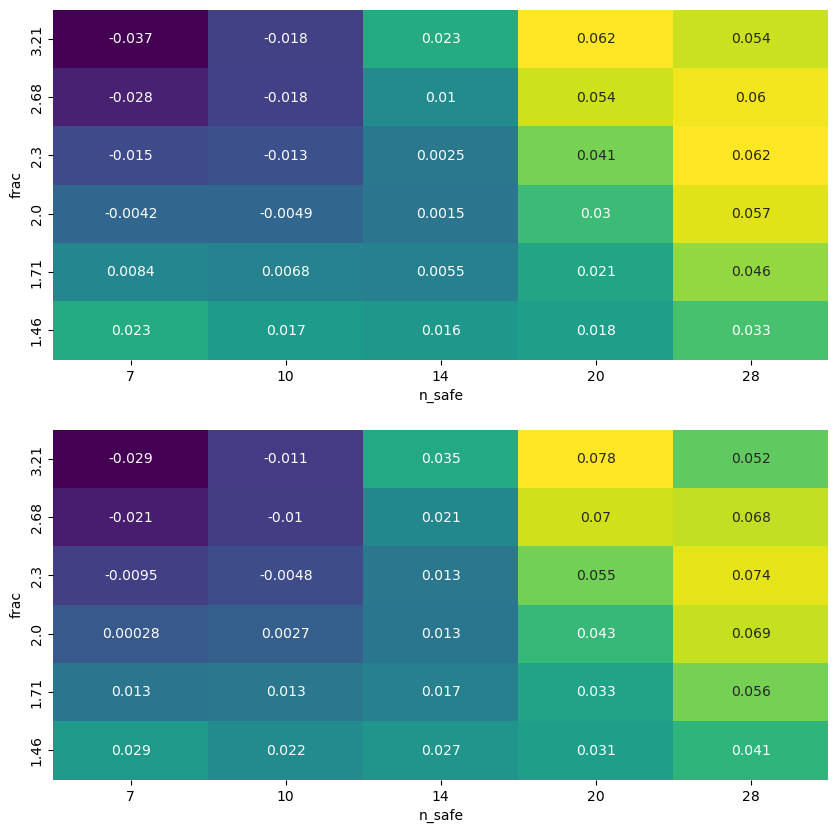

In [330]:
diff = log_tables.loc['IPS'] - log_tables.loc['Vertex']

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
# sns.heatmap(diff., annot=True, cmap='coolwarm', center=0, ax=ax, cbar=False)

sns.heatmap(diff.loc[True].iloc[::-1], annot=True, cmap='viridis', ax=axes[0], cbar=False)

sns.heatmap(diff.loc[False].iloc[::-1], annot=True, cmap='viridis', ax=axes[1], cbar=False)

# ax.set(xlabel='Safe payoff', ylabel='Risky-safe payoff ratio')
# ax.set_title('IPS - Vertex stimulation, Risky first')





In [326]:
axes

array([<Axes: >, <Axes: >], dtype=object)

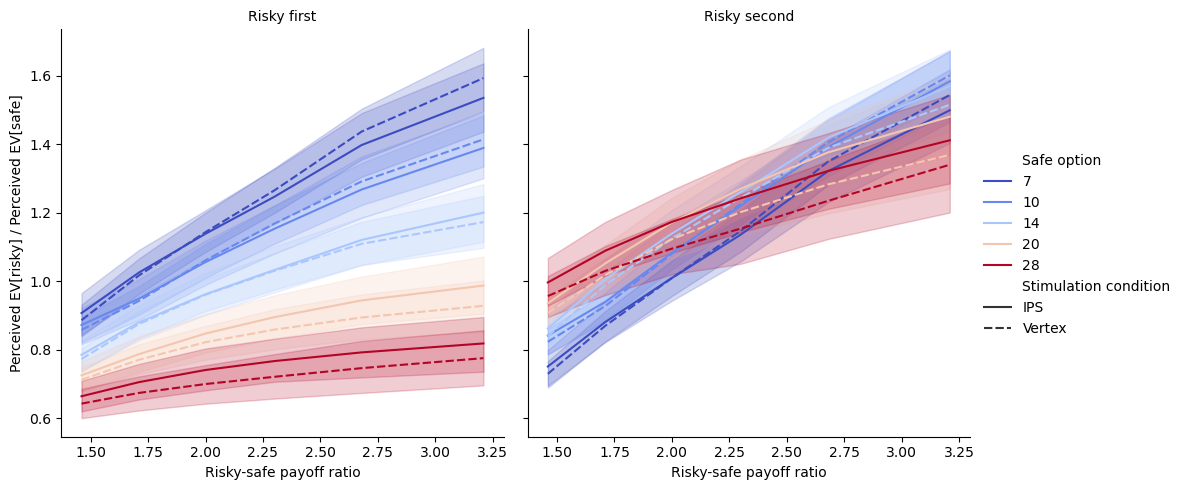

In [309]:

ev['Order'] = ev['risky_first'].map({True: 'Risky first', False: 'Risky second'})

ev['Safe option'] = ev['n_safe']
ev['Stimulation condition'] = ev['stimulation_condition']

g = sns.relplot(x='frac', y='ev_ratio', hue='Safe option', col='Order', style='Stimulation condition', data=ev, kind='line', markers=False, palette='coolwarm')

g.set_titles('{col_name}')

g.set(xlabel='Risky-safe payoff ratio', ylabel='Perceived EV[risky] / Perceived EV[safe]')

In [18]:
vmin, vmax = np.log(1./key), np.log(key)

In [19]:
vmin, vmax

(-0.37156355643248296, 0.371563556432483)

<Axes: xlabel='n_safe', ylabel='frac'>

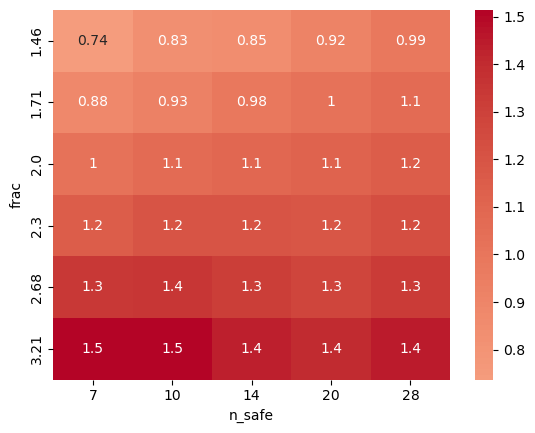

In [20]:
sns.heatmap(tables.loc['vertex', False], annot=True, cmap='coolwarm', center=0)

<Axes: xlabel='n_safe', ylabel='frac'>

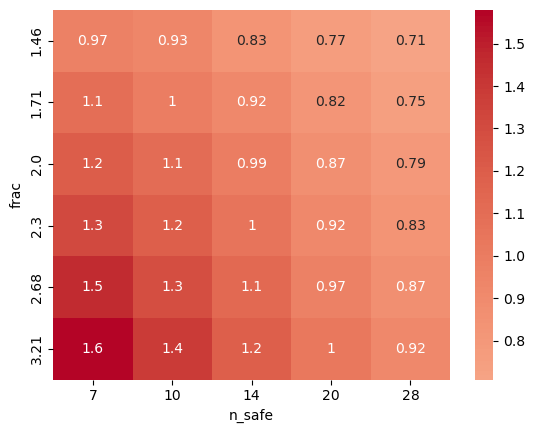

In [21]:
sns.heatmap(tables.loc['ips', True], annot=True, cmap='coolwarm', center=0)

<Axes: xlabel='n_safe', ylabel='frac'>

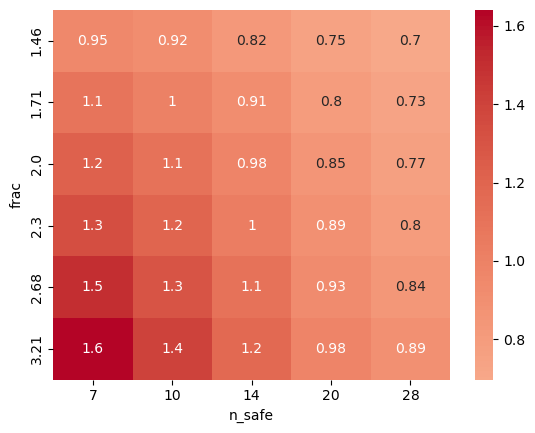

In [22]:
sns.heatmap(tables.loc['vertex', True], annot=True, cmap='coolwarm', center=0)

# Only frac 1/.55

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_51507/1298834291.py:19: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  ev_risky = ev_risky.stack(level=[0, 1]).to_frame('EV_percept[risky]')
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_51507/1298834291.py:20: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  ev_safe = ev_safe.stack(level=[0, 1]).to_frame('EV_percept[safe]')


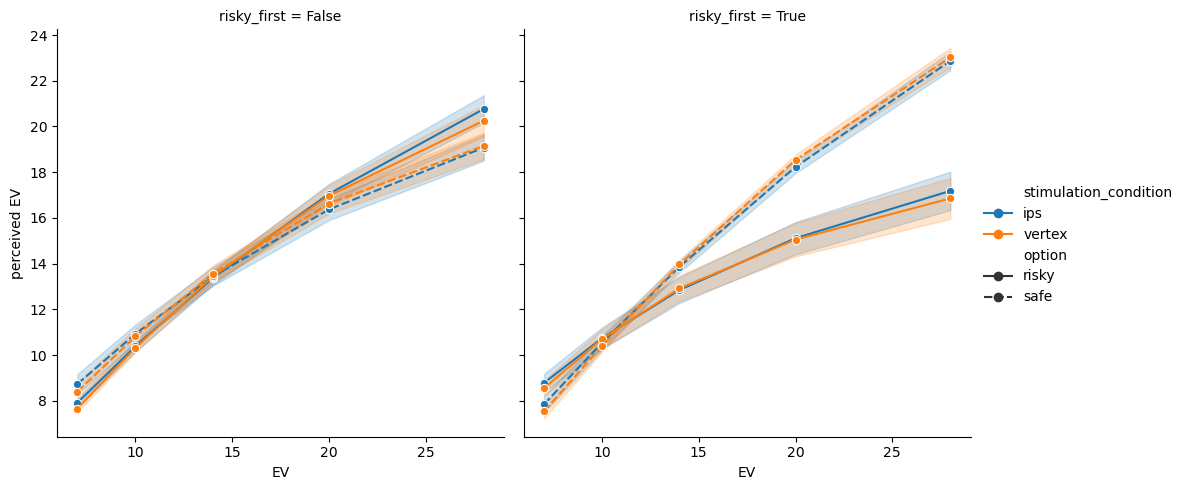

In [23]:
frac = [1./.55]
safe_n = np.array([7, 10, 14, 20, 28])

paradigm = pd.MultiIndex.from_product([safe_n, frac, [0.55, 1.0]], names=['n_safe', 'frac', 'p1']).to_frame(index=False)
paradigm['n_risky'] = np.round(paradigm['n_safe'] * paradigm['frac'])
paradigm['risky_first'] = paradigm['p1'] == 0.55
# p2 is .55 when p1 is 1.0, and 1.0 when p1 is .55
paradigm['p2'] = np.where(paradigm['p1'] == 0.55, 1.0, 0.55)
paradigm['n1'] = np.where(paradigm['risky_first'], paradigm['n_risky'], paradigm['n_safe'])
paradigm['n2'] = np.where(paradigm['risky_first'], paradigm['n_safe'], paradigm['n_risky'])

# paradigm.drop('frac', axis=1, inplace=True)
ev_risky = paradigm.apply(get_ev_risky, axis=1)
ev_risky.index = pd.MultiIndex.from_frame(paradigm)

ev_safe = paradigm.apply(get_ev_safe, axis=1)
ev_safe.index = pd.MultiIndex.from_frame(paradigm)

ev_risky = ev_risky.stack(level=[0, 1]).to_frame('EV_percept[risky]')
ev_safe = ev_safe.stack(level=[0, 1]).to_frame('EV_percept[safe]')

ev = pd.concat([ev_risky, ev_safe], axis=1)

ev['EV[risky]'] = ev.index.get_level_values('n_risky') * .55
ev['EV[safe]'] = ev.index.get_level_values('n_safe')


ev['EV'] = ev['EV[safe]']
ev.set_index('EV', append=True, inplace=True)

ev = ev[['EV_percept[risky]', 'EV_percept[safe]']]
ev.columns = ['risky', 'safe']
ev.columns.name = 'option'

ev = ev.stack().to_frame('perceived EV')

sns.relplot(x='EV', y='perceived EV', hue='stimulation_condition', col='risky_first', data=ev.reset_index(), kind='line', marker='o', style='option', errorbar='se')

In [207]:
ev

EV_percept[risky]  \
n_safe frac     p1   n_risky risky_first p2   n1   n2   subject stimulation_condition                      
7      1.464286 0.55 10.0    True        1.00 10.0 7.0  1       IPS                             5.834123   
                                                                Vertex                          5.745985   
                                                        2       IPS                             7.599639   
                                                                Vertex                          7.168028   
                                                        3       IPS                             6.734002   
...                                                                                                  ...   
28     3.214286 1.00 90.0    False       0.55 28.0 90.0 69      Vertex                         31.354238   
                                                        72      IPS                            26.629683   
                                                                Vertex                         24.045680   
                                                        74      IPS                            19.946891   
                                                                Vertex                         20.946163   

                                                                                       EV_percept[safe]  \
n_safe frac     p1   n_risky risky_first p2   n1   n2   subject stimulation_condition                     
7      1.464286 0.55 10.0    True        1.00 10.0 7.0  1       IPS                            7.370120   
                                                                Vertex                         7.100343   
                                                        2       IPS                            7.254533   
                                                                Vertex                         7.105872   
                                                        3       IPS                            7.382536   
...                                                                                                 ...   
28     3.214286 1.00 90.0    False       0.55 28.0 90.0 69      Vertex                        19.302639   
                                                        72      IPS                           19.321832   
                                                                Vertex                        22.117033   
                                                        74      IPS                           21.383526   
                                                                Vertex                        20.982315   

                                                                                       EV[risky]  \
n_safe frac     p1   n_risky risky_first p2   n1   n2   subject stimulation_condition              
7      1.464286 0.55 10.0    True        1.00 10.0 7.0  1       IPS                          5.5   
                                                                Vertex                       5.5   
                                                        2       IPS                          5.5   
                                                                Vertex                       5.5   
                                                        3       IPS                          5.5   
...                                                                                          ...   
28     3.214286 1.00 90.0    False       0.55 28.0 90.0 69      Vertex                      49.5   
                                                        72      IPS                         49.5   
                                                                Vertex                      49.5   
                                                        74      IPS                         49.5   
                                                                Vertex                    

In [26]:
ev

perceived EV
n_safe frac     p1   n_risky risky_first p2   n1   n2   subject stimulation_condition EV option              
7      1.818182 0.55 13.0    True        1.00 13.0 7.0  1       ips                   7  risky       7.144535
                                                                                         safe        7.411642
                                                                vertex                7  risky       7.144832
                                                                                         safe        7.166688
                                                        2       ips                   7  risky      13.226260
...                                                                                                       ...
28     1.818182 1.00 51.0    False       0.55 28.0 51.0 72      vertex                28 safe       18.194962
                                                        74      ips                   28 risky      16.530538
                                                                                         safe       22.571202
                                                                vertex                28 risky      15.476979
                                                                                         safe       21.928214

[1400 rows x 1 columns]